<a href="https://colab.research.google.com/github/vrmusketeers/FYP-DS/blob/main/Initial%20Analysis/Pre_Processed_ABIDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification based on ABIDE Pre-processed Dataset. 
This is a classification based on machine learning models. Here we try to classify three different things. We can see these three areas as mentione below:-



1.   Classification of the ABIDE Pre-porcessed data for the classification of Autistic Patients
2.   Classification of the symptom the person is experiencing right now

NOTE this data is only Focused on DX_GROUP being 1,2. If we need any other phenotype we might have to add those to the menu as well.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install nilearn

In [ ]:
# importing all the required libraries
import pandas as pd
import numpy as np

# For NiLearn
from nilearn import datasets
from nilearn import plotting
from nilearn import image
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

# For Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Form sklearn
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, precision_recall_curve, recall_score, precision_score, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_predict, cross_val_score

from prettytable import PrettyTable
from matplotlib.colors import ListedColormap
import time as time
from joblib import dump, load

## Constant Declerations

In [ ]:
# Papameters for the sample size and study
n_subjects = 100
DX_GROUP = {1,2}
# DSM_IV_TR = [0,1,2,3,4]
data_dir = '/content/drive/Shareddrives/Final Project/Colabs/Data/ABIDE_NILEARN'
PRE_PROCESSED_FEATURE_DATA = '/content/drive/Shareddrives/Final Project/Colabs/Data/ABIDE_NILEARN/ABIDE_PREPROCESSED_DATA_FEATURES_EXTRACTED'
MODEL_STORAGE_PATH = '/content/drive/Shareddrives/Final Project/Colabs/Machine Learning Deep Learning/Models/Pre_Processed_ABIDE_Model'

## Utility Functions

All utility functions goes here. Muller Loop serves as a classifier and we are sunning several classifier to classify the binary data which tells us whether the person has Autism or not

In [ ]:
# Muller Loop Classifier
def muller_loop_classifier(classifier_names, classifiers, X, y,executionType):
  result = PrettyTable()
  result.field_names = ["Model", "Accuracy", "F1 Score", "Precision", "Recall"]

  #X = StandardScaler().fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=437)

  from sklearn.preprocessing import StandardScaler
  from sklearn.preprocessing import MinMaxScaler
  sc = MinMaxScaler()
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform (X_test)
  max_score = 0.0
  max_class = ''
  # iterate over classifiers
  for name, clf in zip(classifier_names, classifiers):
      start_time = time.time()
      clf.fit(X_train, y_train)
      score = 100.0 * clf.score(X_test, y_test)
      y_pred = clf.predict(X_test)
      f1Score = f1_score(y_test, y_pred, average="macro")
      print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))
      precision = precision_score(y_test, y_pred, average='macro')
      recall = recall_score(y_test, y_pred, average='macro')
      result.add_row([name, score, f1Score, precision, recall])
      if score > max_score:
          clf_best = clf
          max_score = score
          max_class = name

      labels = clf.predict(X_train)
  modelName=executionType+"_"+max_class
  filePath = MODEL_STORAGE_PATH+"/"+modelName
  dump(clf_best, filePath)
  print(result)

# Data Download and Analysis

In this section we are downloading 100 records for time being  and the records are in a 50-50 split. So we will have 50 people with Autism and 50 without. 

NOTE: This is ABIDE 1 dataset which is pre-processed

In [ ]:
# Downloading the ABIDE dataset with 
data = datasets.fetch_abide_pcp(n_subjects=n_subjects, 
                                DX_GROUP=DX_GROUP, 
                                DSM_IV_TR=DSM_IV_TR,
                                data_dir=data_dir)

Getting the total number of participants in the above downloaded data. 

In [ ]:
# Number of samples
print('The total number of participants are', len(data.func_preproc))

The total number of participants are 100


Downloading the brain atlas and visualizing it in order to showcase the various regions of the brain

In [ ]:
parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064

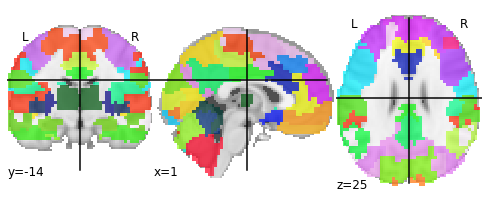

In [ ]:
plotting.plot_roi(atlas_filename, draw_cross=True)

**Loading 4D Timeseries data for one single subject using the Brain Atlas.** 

Lets extract the first image and also check where on the disc these images are loaded up. In later point in time we can go ahead and move these to a specific Google Drive Folder.

Below mentioned are the 20 fMRI files that are downloaded.

In [ ]:
data.func_preproc

In [ ]:
fmri_filepath = data.func_preproc[0]

In [ ]:
print('The file path related to the first fMRI data is :', fmri_filepath)

The file path related to the first fMRI data is : /content/drive/Shareddrives/Final Project/Colabs/Data/ABIDE_NILEARN/ABIDE_pcp/cpac/nofilt_noglobal/Pitt_0050003_func_preproc.nii.gz


As its a 4D image we will look at only one slice at a time and averaging it will give us an edge for doing the same.

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/find_cuts.py:141: UserWarning: Could not determine cut coords: All voxels were masked by the thresholding. Returning the center of mass instead.
  "Could not determine cut coords: "
/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


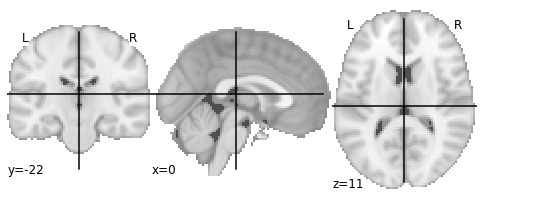

In [ ]:
avg_image = image.mean_img(fmri_filepath)
plotting.plot_stat_map(avg_image,threshold=2000)


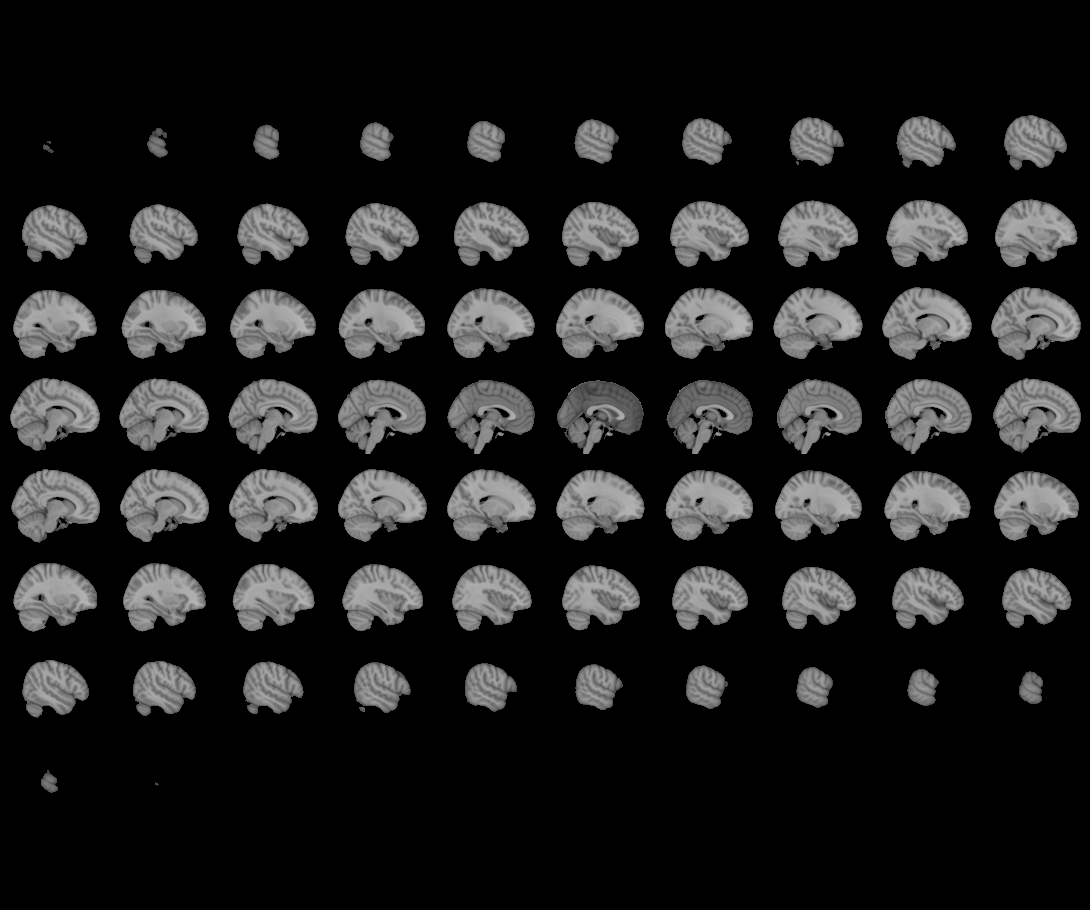
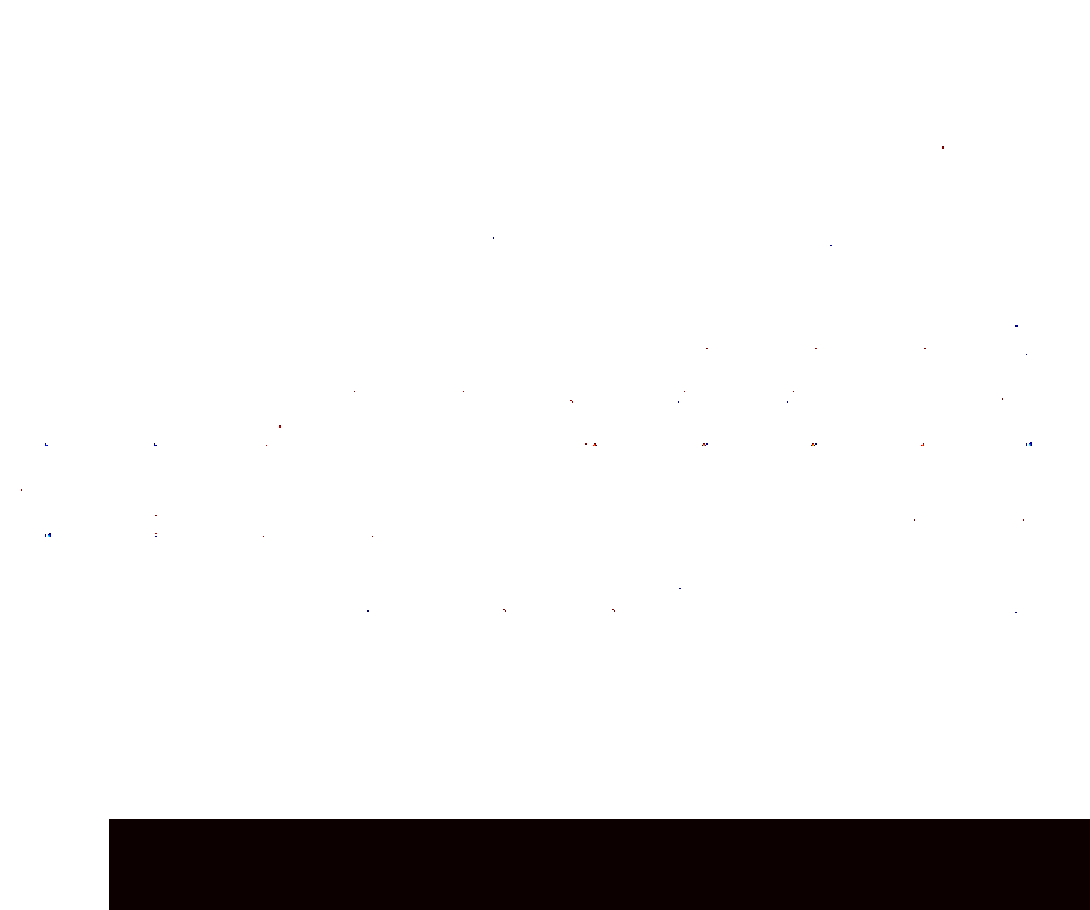

In [ ]:
plotting.view_img(avg_image)

In [ ]:
masker = NiftiLabelsMasker(labels_img=atlas_filename, 
                           smoothing_fwhm=6,
                           standardize=True, 
                           t_r=2.5,
                           low_pass=0.1,
                           high_pass=0.01,
                           detrend=True,
                           memory='nilearn_cache',
                           verbose=1)
                         

# We convert the nifti files to the time series sigals. Its then stored into a Numpy array.
# Regressed Confounds are being used to extract signals
print(data.func_preproc)

['/content/drive/Shareddrives/Final Project/Colabs/Data/ABIDE_NILEARN/ABIDE_pcp/cpac/nofilt_noglobal/Pitt_0050003_func_preproc.nii.gz', '/content/drive/Shareddrives/Final Project/Colabs/Data/ABIDE_NILEARN/ABIDE_pcp/cpac/nofilt_noglobal/Pitt_0050004_func_preproc.nii.gz', '/content/drive/Shareddrives/Final Project/Colabs/Data/ABIDE_NILEARN/ABIDE_pcp/cpac/nofilt_noglobal/Pitt_0050005_func_preproc.nii.gz', '/content/drive/Shareddrives/Final Project/Colabs/Data/ABIDE_NILEARN/ABIDE_pcp/cpac/nofilt_noglobal/Pitt_0050006_func_preproc.nii.gz', '/content/drive/Shareddrives/Final Project/Colabs/Data/ABIDE_NILEARN/ABIDE_pcp/cpac/nofilt_noglobal/Pitt_0050007_func_preproc.nii.gz', '/content/drive/Shareddrives/Final Project/Colabs/Data/ABIDE_NILEARN/ABIDE_pcp/cpac/nofilt_noglobal/Pitt_0050008_func_preproc.nii.gz', '/content/drive/Shareddrives/Final Project/Colabs/Data/ABIDE_NILEARN/ABIDE_pcp/cpac/nofilt_noglobal/Pitt_0050010_func_preproc.nii.gz', '/content/drive/Shareddrives/Final Project/Colabs/Data

In [ ]:
# The confounds were not available in pre-processed data. That needs to be found.
time_series = masker.fit_transform(fmri_filepath)

[NiftiLabelsMasker.fit_transform] loading data from /root/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
Resampling labels


We got 64 regions of interest and 196 volumes. Need to understand the region and volumes more

In [ ]:
time_series.shape

(196, 64)

In [ ]:
corr_measure = ConnectivityMeasure(kind='correlation')
corr_matrix = corr_measure.fit_transform([time_series])[0]
corr_matrix.shape

(64, 64)

The below mentioned Correlation Matrix represents that the functional areas are highly correlated and the BOLD signals are highly correlated.

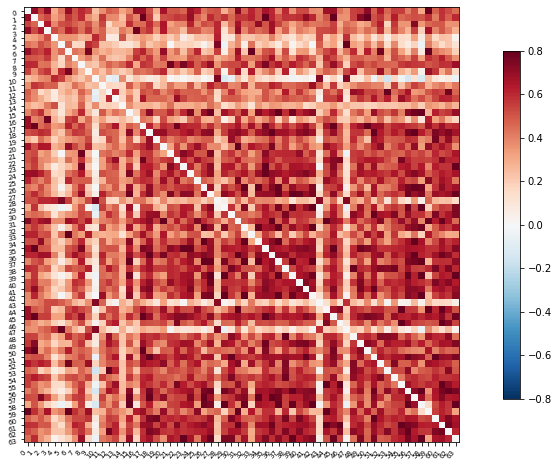

In [ ]:
np.fill_diagonal(corr_matrix,0)

plotting.plot_matrix(corr_matrix, 
                     figure=(10,8),
                     labels=range(time_series.shape[-1]),
                     vmax=0.8,
                     vmin=-0.8,
                     reorder=False)

# Data Pre-Processing for the Entire Dataset

In [ ]:
# Loading the atlas for analysis of the entire data set
multiscale = datasets.fetch_atlas_basc_multiscale_2015()
atlas_filename = multiscale.scale064

# initialize the masker with a new Verbosity
masker = NiftiLabelsMasker(labels_img=atlas_filename, 
                           smoothing_fwhm=6,
                           standardize=True, 
                           t_r=2.5,
                           low_pass=0.1,
                           high_pass=0.01,
                           detrend=True,
                           memory='nilearn_cache',
                           verbose=0)

# initialization of the correlation measure for the set to vectorize
corr_measure = ConnectivityMeasure(kind='correlation',
                                   vectorize=True,
                                   discard_diagonal=True)

Looping through the entire data in order to get the values from the entire dataset.

In [ ]:
all_extracted_features = []

for i, sub in enumerate(data.func_preproc):
  # extraction of the timeseries values
  time_series = masker.fit_transform(sub)
  # create a region x region correlation matrix
  corr_matrix = corr_measure.fit_transform([time_series])[0]
  # push it into the all_extracted_feature container
  all_extracted_features.append(corr_matrix)
  # Printing in order to keep track of the data being processed
  print('The number of records processes are ', i)

Searilizing the features into a pre-processed data file using numpy.

In [ ]:
# Save the features to a disk using numpy
np.savez_compressed(PRE_PROCESSED_FEATURE_DATA, a=all_extracted_features)

**Loading the Dataset that is stored using Numpy**

NOTE - Dont rerun the entire pipeline. Just use the data below. You can load this data and get things working.

In [ ]:
X_features = np.load(PRE_PROCESSED_FEATURE_DATA+'.npz')['a']

Printing the shape shows that we are having 100 samples and 2016 correlation coefficient. (64(64-1)/2)

In [ ]:
X_features.shape

(100, 2016)

Visualizing the feature Matrix

Text(0, 0.5, 'Subjects')

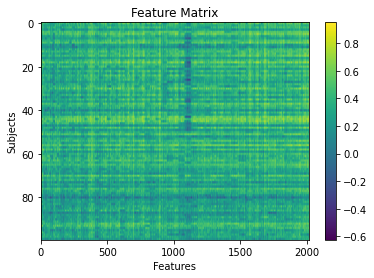

In [ ]:
plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('Feature Matrix')
plt.xlabel('Features')
plt.ylabel('Subjects')


Getting the y Labels for various types of classification


In [ ]:
pheno = pd.DataFrame(data.phenotypic)
pheno.head()

,i,Unnamed_0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,FIQ_TEST_TYPE,VIQ_TEST_TYPE,PIQ_TEST_TYPE,ADI_R_SOCIAL_TOTAL_A,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_ONSET_TOTAL_D,ADI_R_RSRCH_RELIABLE,ADOS_MODULE,ADOS_TOTAL,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV,ADOS_RSRCH_RELIABLE,ADOS_GOTHAM_SOCAFFECT,ADOS_GOTHAM_RRB,ADOS_GOTHAM_TOTAL,ADOS_GOTHAM_SEVERITY,SRS_VERSION,SRS_RAW_TOTAL,SRS_AWARENESS,SRS_COGNITION,SRS_COMMUNICATION,SRS_MOTIVATION,...,WISC_IV_SIM_SCALED,WISC_IV_VOCAB_SCALED,WISC_IV_INFO_SCALED,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI,anat_cnr,anat_efc,anat_fber,anat_fwhm,anat_qi1,anat_snr,func_efc,func_fber,func_fwhm,func_dvars,func_outlier,func_quality,func_mean_fd,func_num_fd,func_perc_fd,func_gsr,qc_rater_1,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,1,2,50003,2,50003,b'PITT',b'Pitt_0050003',1,1,24.45,1,b'R',NaN,124.0,128,115,b'WASI',b'WASI',b'WASI',27,22,5,3,1,4,13,5,8,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,NaN,NaN,7.165701,1.126752,10.460008,4.282238,0.161716,9.241155,0.578301,56.286350,2.012112,0.949857,0.000474,0.031781,0.322092,135,67.164179,0.041862,b'OK',b'',b'OK',b'',b'OK',b'',b'OK',b'',b'OK',b'',1
1,2,3,50004,3,50004,b'PITT',b'Pitt_0050004',1,1,19.09,1,b'R',NaN,113.0,108,117,b'WASI',b'WASI',b'WASI',19,12,5,3,1,4,18,6,12,2,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,NaN,NaN,7.698144,1.226218,9.725750,3.881684,0.174186,9.323463,0.578960,63.317943,1.866104,1.180605,0.008262,0.014260,0.127745,29,14.427861,0.046745,b'OK',b'',b'OK',b'',b'OK',b'',b'OK',b'',b'OK',b'',1
2,3,4,50005,4,50005,b'PITT',b'Pitt_0050005',1,1,13.73,2,b'R',NaN,119.0,117,118,b'WASI',b'WASI',b'WASI',23,19,3,4,1,4,12,4,8,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,NaN,NaN,9.071807,1.256278,11.198226,3.628667,0.119269,10.814200,0.556064,70.800354,1.918278,1.092030,0.001711,0.019205,0.128136,22,10.945274,0.027963,b'OK',b'',b'OK',b'',b'maybe',b'ic-parietal-cerebellum',b'OK',b'',b'OK',b'',0
3,4,5,50006,5,50006,b'PITT',b'Pitt_0050006',1,1,13.37,1,b'L',NaN,109.0,99,119,b'WASI',b'WASI',b'WASI',13,10,4,3,1,4,12,4,8,4,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,NaN,NaN,8.026798,1.407166,6.282055,3.674539,0.130647,10.123574,0.562942,75.364679,2.213873,1.086830,0.001500,0.006919,0.070143,3,1.492537,0.054006,b'OK',b'',b'OK',b'',b'maybe',b'ic-parietal slight',b'OK',b'',b'OK',b'',1
4,5,6,50007,6,50007,b'PITT',b'Pitt_0050007',1,1,17.78,1,b'R',NaN,110.0,106,112,b'WASI',b'WASI',b'WASI',21,14,9,1,1,3,17,5,12,2,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,NaN,NaN,5.775897,1.161231,6.991093,4.104707,0.236214,7.638746,0.607554,64.682109,1.834521,1.099380,0.002805,0.028284,0.151246,38,18.905473,0.055615,b'OK',b'',b'OK',b'',b'maybe',b'ic-cerebellum_temporal_lob',b'OK',b'',b'OK',b'',1


In [ ]:
pheno.DSM_IV_TR.unique()

array([1, 0, 2])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


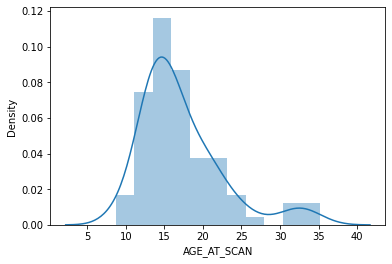

In [ ]:
# Visualizing some data points
sns.distplot(pheno.AGE_AT_SCAN)

In [ ]:
# Lets find the counts of the various autistic and non autistic patients. We see a mix of values
# This is a very well balanced distribution.
pheno.DX_GROUP.value_counts()

2    55
1    45
Name: DX_GROUP, dtype: int64

# Classification Algorithms Using Loops

1.   Nearest Neighbors
2.   Linear SVM
3.   RBF SVM
4.   Gaussian Process
5.   Decision Tree
6.   Random Forest
7.   Neural Net
8.   AdaBoost
9.   Naive Bayes
10.  QDA



In [ ]:
classifier_names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(2.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [ ]:
X = X_features
y = pheno['DX_GROUP']

In [ ]:
pheno.DSM_IV_TR

0     1
1     1
2     1
3     1
4     1
     ..
95    0
96    0
97    0
98    0
99    0
Name: DSM_IV_TR, Length: 100, dtype: int64

In [ ]:
type="classifier_AUTISM"
type_spec="classifier_AUTISM_SPECTRUM"
muller_loop_classifier(classifier_names, classifiers, X, y,type)

Classifier = Nearest Neighbors, Score (test, accuracy) = 57.50, Training time = 0.02 seconds
Classifier = Linear SVM, Score (test, accuracy) = 55.00, Training time = 0.02 seconds
Classifier = RBF SVM, Score (test, accuracy) = 55.00, Training time = 0.03 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier = Gaussian Process, Score (test, accuracy) = 60.00, Training time = 0.11 seconds
Classifier = Decision Tree, Score (test, accuracy) = 65.00, Training time = 0.04 seconds
Classifier = Random Forest, Score (test, accuracy) = 50.00, Training time = 0.03 seconds
Classifier = Neural Net, Score (test, accuracy) = 60.00, Training time = 2.05 seconds
Classifier = AdaBoost, Score (test, accuracy) = 70.00, Training time = 0.61 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 60.00, Training time = 0.01 seconds
Classifier = QDA, Score (test, accuracy) = 47.50, Training time = 0.02 seconds
+-------------------+-------------------+---------------------+--------------------+--------------------+
|       Model       |      Accuracy     |       F1 Score      |     Precision      |       Recall       |
+-------------------+-------------------+---------------------+--------------------+--------------------+
| Nearest Neighbors | 57.49999999999999 |  0.5682539682539682 | 0.6054131054

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
